<h1 align='center'>Machine Learning Lab</h1>
<h3 align='center'>Lab 07</h3>

#### Importing Packages

In [1]:
import os                                  #Importing OS
import pandas as pd                        #Importing Pandas
import numpy as np                         #Importing Numpy
import matplotlib.pyplot as plt            #Importing Matplotlib
import random                              #Importing Random
from scipy.spatial.distance import pdist   #Importing Scipy pdist

### Exercise 0: Dataset Preprocessing

In [2]:
#Initializing a random seed to be used for sampling
random_seed = 3116

##### Function to check for Padding and if needed pad with 0s

In [3]:
def check_for_padding(df):
    
    #Getting the Maximum row size to match for
    max_row_size = df.shape[1]
    
    #Iterating through all rows of the provided dataframe
    for index, row in df.iterrows():
        
        #Extracting the last index till where there is any valid value and adding 1 to convert this into total valid values
        total_valid_values = row.last_valid_index() + 1
        
        #If total valid values in a row is less than maximum number values then we do padding
        if total_valid_values < max_row_size:
            
            #Padding from the left with 0s
            df.iloc[index,:] = row.shift(max_row_size - total_valid_values, fill_value=0)
    
    #Returning the modified dataframe
    return df

##### Function to Merge Two Dataframes having same columns and Structure

In [4]:
def merge_dataframes(df1 ,df2):
    #Checking if both the dataframe have same number of columns
    if len(df1.columns) != len(df2.columns):
        raise Exception('For Merging Two Dataframes, the number of columns in both Dataframes should be equal')
    
    #Checking for variable sample length in dataframe 1 and doing padding if necessary
    df1 = check_for_padding(df1)
    
    #Checking for variable sample length in dataframe 2 and doing padding if necessary
    df2 = check_for_padding(df2)
    
    #Returning the Concatenation of Dataframe 1 and Dataframe 2 and reassigning the index values
    return pd.concat([df1 ,df2], ignore_index = True)

##### Function to do splitting into Training and Test set using Stratified Sampling

In [5]:
def stratify_split_dataframe(df ,train_ratio ,validation_ratio, test_ratio):
    #Shuffling the dataset to induce the Randomization in the dataset
    df = df.sample(frac = 1, random_state = random_seed).reset_index(drop = True)
    
    #Creating Matrix X by droping the class column
    X = df.drop(0,axis=1)
    
    #Creating the Y column vector by only taking the class column
    Y = df.iloc[:,0].to_numpy()
    
    #Appending the bias column of 1 in the starting of Matrix X
    X = np.append(np.ones(shape=(len(X),1)),X,axis=1)
    
    #Calculating the total rows for Train and Validation sets
    total_rows_train = int(len(X)*train_ratio)
    total_rows_validation = int(len(X)*validation_ratio)
    
    #Splitting the dataset into Train, Validation and Testing sets
    X_train , X_val , X_test = X[:total_rows_train,:] , X[total_rows_train:total_rows_train + total_rows_validation,:] , X[total_rows_train + total_rows_validation:,:]
    Y_train , Y_val , Y_test = Y[:total_rows_train].reshape(-1,1) , Y[total_rows_train:total_rows_train + total_rows_validation].reshape(-1,1) , Y[total_rows_train + total_rows_validation:].reshape(-1,1)
    
    #Returing the Splitted datasets
    return X_train, Y_train, X_test, Y_test, X_val, Y_val

##### Function to Normalize and Standardize the dataset by removing the mean and scaling to unit-variance

In [6]:
def normalize_dataset(df):
    #Returing (x-mean)/standard Deviation
    return (df - df.mean())/df.std()

##### Preprocessing the datasets

In [7]:
#Base path for all the datasets
base_path = 'UCRArchive_2018/'

#Train file Suffix
train_file_suffix = '_TRAIN.tsv'

#Test File Suffix
test_file_suffix = '_TEST.tsv'

#List containing the folder names to exclude from processing
exclude_folders = ['Missing_value_and_variable_length_datasets_adjusted']

In [8]:
#A dictionary to contain the statistics of all the datasets
dataset_stats = {'Name' : [],
                 'Total Columns' : [],
                 'Total Rows' : [],
                 'Total Classes' : [],
                 'Null Values' : []}

In [9]:
#A dictionary to contain the processed dataframes for each datasets
datasets = {'Name' : [],
            'Dataset' : []}

##### Scanning the Dataset Folders and extracting all the train and test data files for processing

In [10]:
#Using the os package to scan the base dataset folder
with os.scandir(base_path) as entries:
    for entry in entries:
        #Checking if entry is a directory and is not in the excluded folders list
        if (entry.is_dir()) and (entry.name not in exclude_folders):
            
            #Formating the training and testing file name
            train_filename = '{}/{}'.format(entry.path, entry.name + train_file_suffix) 
            test_filename = '{}/{}'.format(entry.path, entry.name + test_file_suffix)
            
            #Reading the Train and Test CSV file using Pandas
            train_df , test_df = pd.read_csv(train_filename , sep='\t' , header = None) , pd.read_csv(test_filename , sep='\t' , header = None)
            
            #Merging the Train and Test Dataframes
            merged_df = merge_dataframes(train_df,test_df)
            
            #Storing the stats of this dataset into our Dictionary
            dataset_stats['Name'].append(entry.name)
            dataset_stats['Total Columns'].append(len(merged_df.columns))
            dataset_stats['Total Rows'].append(merged_df.shape[0])
            dataset_stats['Total Classes'].append(len(merged_df.iloc[:,0].unique()))
            dataset_stats['Null Values'].append(merged_df.isnull().values.any())
            
            #Storing the Processed Dataframe into the created dictionary
            datasets['Name'].append(entry.name)
            datasets['Dataset'].append(merged_df)

##### Converting the Dictionary to the Dataframe for Displaying purposes

In [11]:
dataset_info = pd.DataFrame.from_dict(dataset_stats)
dataset_info

,Name,Total Columns,Total Rows,Total Classes,Null Values
0,ACSF1,1461,200,10,False
1,Adiac,177,781,37,False
2,AllGestureWiimoteX,501,1000,1,False
3,AllGestureWiimoteY,501,1000,1,False
4,AllGestureWiimoteZ,501,1000,1,False
...,...,...,...,...,...
123,Wine,235,111,2,False
124,WordSynonyms,271,905,25,False
125,Worms,901,258,5,False
126,WormsTwoClass,901,258,2,False


##### Plotting interesting statistics

###### Plotting Datasets versus Total Columns

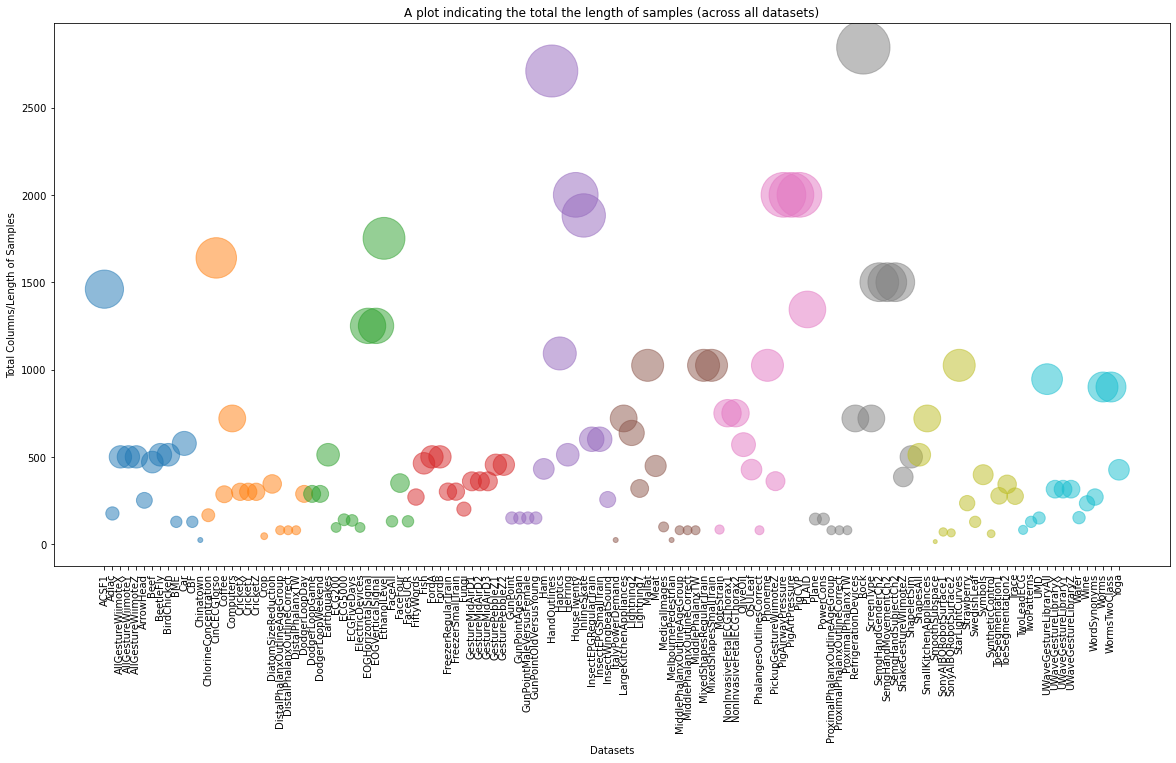

In [12]:
#Creating a Figure
fig = plt.figure(figsize=(20,10))

#Creating an array containing marker size of each dataset
marker_size = dataset_stats['Total Columns']

#Creating an array containing the color code for each dataset
colors = [plt.cm.tab10(i/float(len(dataset_stats['Total Columns'])-1)) for i in range(len(dataset_stats['Total Columns']))]

#Plotting the scatter plot
plt.scatter(dataset_stats['Name'],dataset_stats['Total Columns'], s = marker_size,c = colors,alpha = 0.5)

#Setting the parameters for the graph
plt.xlabel('Datasets')
plt.ylabel('Total Columns/Length of Samples')
plt.title('A plot indicating the total the length of samples (across all datasets)')
plt.xticks(rotation=90)

#Showing the Graph
plt.show()

###### Plotting Datasets versus Total Classes

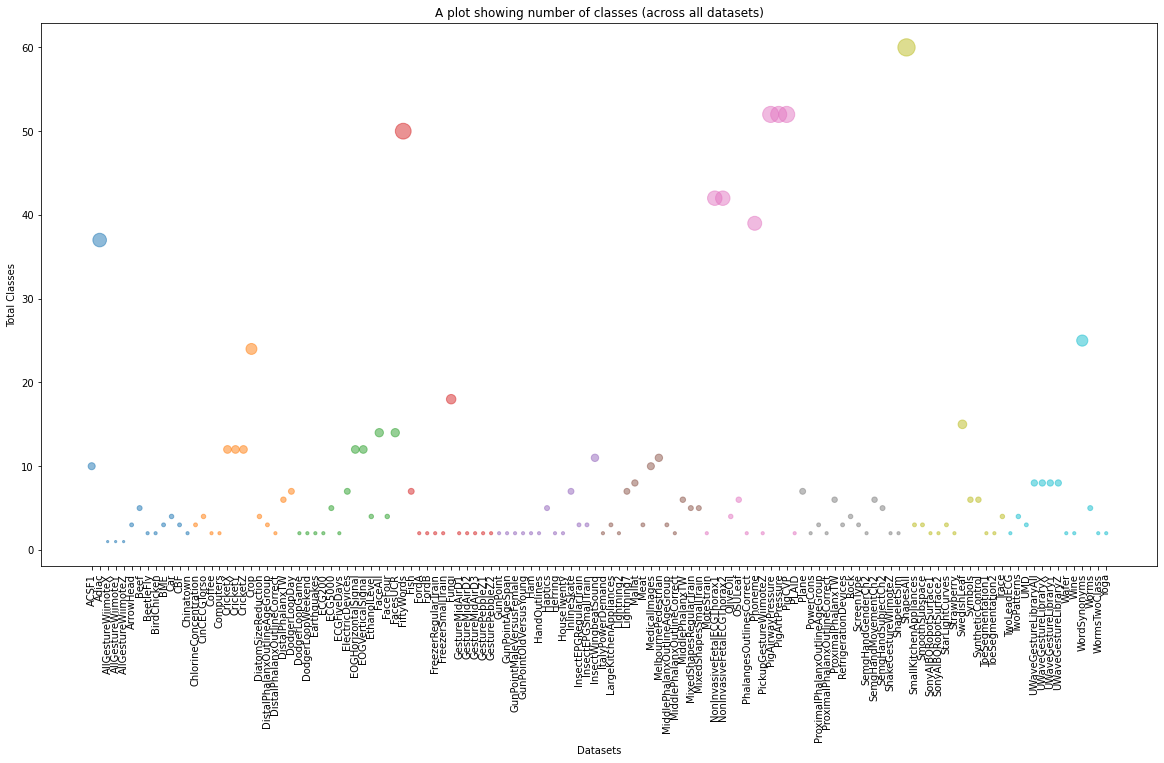

In [13]:
#Creating a Figure
fig = plt.figure(figsize=(20,10))

#Creating an array containing marker size of each dataset
marker_size = np.multiply(dataset_stats['Total Classes'] , 5)

#Creating an array containing the color code for each dataset
colors = [plt.cm.tab10(i/float(len(dataset_stats['Total Classes'])-1)) for i in range(len(dataset_stats['Total Classes']))]

#Plotting the scatter plot
plt.scatter(dataset_stats['Name'],dataset_stats['Total Classes'], s = marker_size,c = colors,alpha = 0.5)

#Setting the parameters for the graph
plt.xlabel('Datasets')
plt.ylabel('Total Classes')
plt.title('A plot showing number of classes (across all datasets)')
plt.xticks(rotation=90)

#Showing the Graph
plt.show()

###### Plotting Datasets versus Total Rows

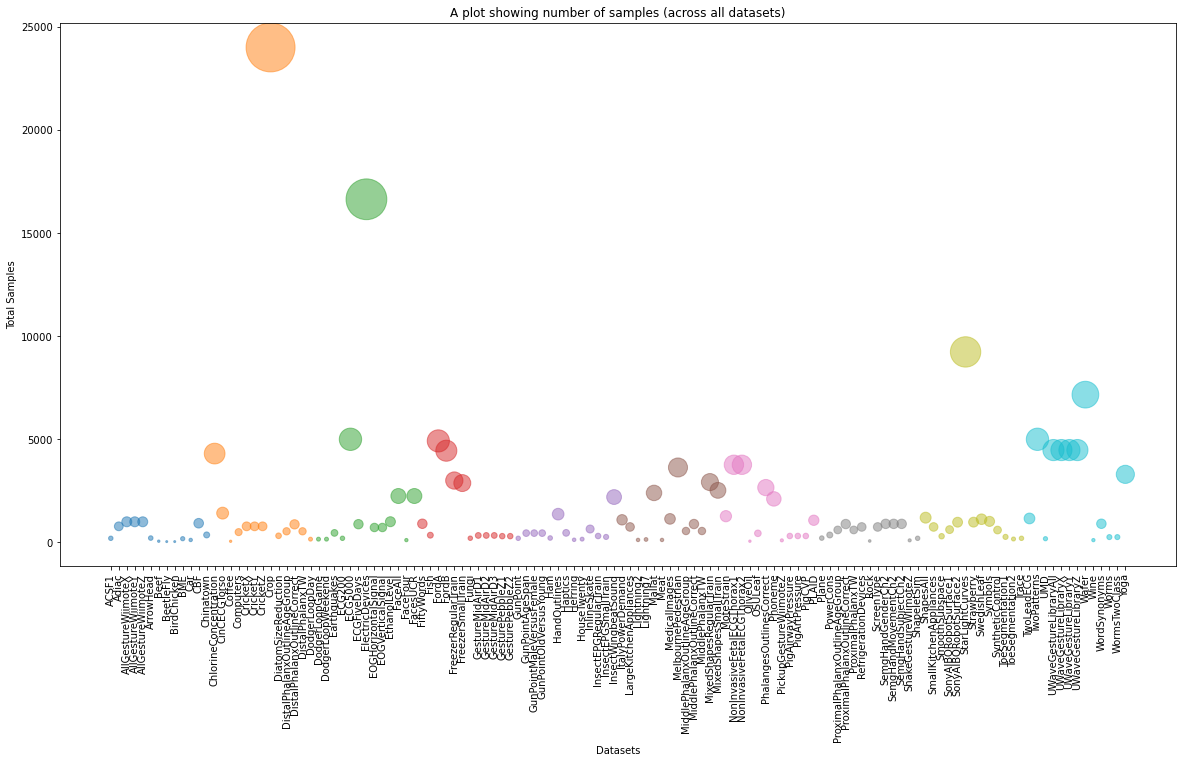

In [50]:
#Creating a Figure
fig = plt.figure(figsize=(20,10))

#Creating an array containing marker size of each dataset
marker_size = np.multiply(dataset_stats['Total Rows'] , 0.1)

#Creating an array containing the color code for each dataset
colors = [plt.cm.tab10(i/float(len(dataset_stats['Total Rows'])-1)) for i in range(len(dataset_stats['Total Rows']))]

#Plotting the scatter plot
plt.scatter(dataset_stats['Name'],dataset_stats['Total Rows'], s = marker_size,c = colors,alpha = 0.5)

#Setting the parameters for the graph
plt.xlabel('Datasets')
plt.ylabel('Total Samples')
plt.title('A plot showing number of samples (across all datasets)')
plt.xticks(rotation=90)

#Showing the Graph
plt.show()

### Exercise 1: Dataset Imputation with KNN

##### List the datasets having missing values

In [15]:
#Extracting Datasets having Some Missing Values
missing_value_datasets = dataset_info[dataset_info['Null Values'] == True]
missing_value_datasets

,Name,Total Columns,Total Rows,Total Classes,Null Values
25,DodgerLoopDay,289,158,7,True
26,DodgerLoopGame,289,158,2,True
27,DodgerLoopWeekend,289,158,2,True
71,MelbournePedestrian,25,3633,11,True


##### For each dataset with missing values, and for each feature (timestep) of it that has missing values imputing the value by calculating the mean of its nearest K neighbors.

###### Function to calculate the euclidean distance between two rows in a dataframe

In [16]:
def calculate_euclidean_distance_df(curr_row ,other_rows):
    sum_square = np.sum(np.square(curr_row - other_rows) ,axis = 1)
    return np.sqrt(sum_square)

###### Function to calculate the euclidean distance between two points in numpy

In [17]:
def calculate_euclidean_distance_numpy(point1 ,point2):
    sum_square = np.sum(np.square(point1 - point2))
    return np.sqrt(sum_square)

###### Function to calculate the mean value from k rows values

In [18]:
def calculate_average_value(other_row ,distance,k):
    #Extracting the k nearest rows with minimum distance
    nearest_rows = other_row.iloc[np.argsort(list(distance))[:k]]
    
    #Returning the mean of all the rows over k rows
    return np.sum(nearest_rows ,axis = 0) / k

###### Function to calculate the accuracy of the KNN model

In [19]:
def accuracy_knn_classification(predicted_classes ,actual_classes):
    #Checking if the size of both predicted classes and actual classes is same
    if len(predicted_classes) != len(actual_classes):
        raise Exception('The size of both Predicted Classes array and Actual Classes array should be same')
    
    #Initializing variable to 0
    correct = 0
    
    #Iterating through all values to match these values
    for i in range(len(predicted_classes)):
        #If values are equal then incrementing the correct variable
        if predicted_classes[i] == actual_classes[i]:
            correct += 1
    
    #Returning the accuracy as the precentage
    return (correct / len(predicted_classes)) * 100

###### Function to impute the missing data in the dataset using KNN approximation

In [20]:
def impute_data_with_KNN(df ,k):
    #Iterating over all rows and finding rows with missing values
    for index, row in df.iterrows():
        
        #Checking if the current row contains any null values
        if row.isnull().values.any():
            
            #Calculating the distance between current index row and all other rows
            distance = calculate_euclidean_distance_df(df.iloc[index] ,df.iloc[~df.index.isin([index])])

            #Calculating the mean value of k nearest rows
            average_values = calculate_average_value(df.iloc[~df.index.isin([index])] ,distance ,k)

            #Replacing the Null values with the new calculated values
            row.fillna(average_values ,inplace = True)

            #Replacing the row with the updated row values
            df.iloc[index ,:] = row
        
    #Returning the modified dataframe
    return df

###### Function the predict the class of observation using KNN Classific

In [21]:
def predict_knn_class(trainX ,trainY ,q ,k ,use_scipy, scipy_distance_metric):
    #Initializing an empty distance array
    distance_array = np.zeros(shape=(len(trainX) ,))
    
    #Iterating through all rows of the train X rows for calculating the euclidean distance
    for index, observation in enumerate(trainX):
        
        #If scipy is allowed to use
        if use_scipy:
            try:
                #Creating a query matrix with one row of query and one row of training observation
                query_matrix = np.append(q.reshape(1,-1),observation.reshape(1,-1),axis=0)
                
                #Calculating the distance using Scipy using the provided distance metric
                distance_array[index] = pdist(query_matrix,scipy_distance_metric)[0]
            except:
                #If for any reason, the scipy distance cannot be calculate, then replacing it with positive infinity indicating the maximum distance
                #Replacing it with positive infinity because in the end it will ignored by k nearest neighbour calculation
                distance_array[index] = np.iinfo(np.int32).max
        else:
            #If Scipy is not allowed then
            #Calculating the distance between the queried and the current indexed row using euclidean and saving it in an array
            distance_array[index] = calculate_euclidean_distance_numpy(q ,observation)

    #Extracting the k nearest rows based on distance value
    k_min_distance = np.argsort(distance_array)[:k]
    
    #Getting the classes of these nearest rows
    k_nearest_class = trainY[k_min_distance,:]
    
    #The predicted class is then the maximum occuring class
    values, counts = np.unique(k_nearest_class.ravel(), return_counts=True)
    predicted_class = values[np.argmax(counts)]
    
    #Returning the Predicted class
    return predicted_class

In [22]:
imputation_dataset_accuracy = {
                    'Name' : [],                #Contains the Name of Datasets
                    'Classification K' : [],    #Contains the Optimum K value for Classification found using Grid Search for each Dataset
                    'Imputation K' : [],        #Contains the Optimum K value for Imputation found using Grid Search for each Dataset
                    'Validation Accuracy' : [], #Contains the Best Validation accuracy achieved using the Optimum Classification K value and Optimum Imputation K
                    'Test Accuracy' : []        #Contains the Test Accuracy achieved using the Optimum Classification K value and Optimum Imputation K
                   }

###### Applying Grid Search on K for classification and k for Imputation on every Dataset

In [23]:
#Iterating/Enumerating through all the datasets
for index , dataset in enumerate(datasets['Dataset']):
    
    #Creating a accuracy matrix which will contain the accuracy for each combination of K classification and K Imputation
    accuracy_matrix = np.zeros(shape=(5, 5))
    
    #Splitting the dataset into Train, Validation and Test sets
    X_train, Y_train, X_test, Y_test, X_val, Y_val = stratify_split_dataframe(dataset, 0.7, 0.15, 0.15)
    
    #Iterating through different values of K for KNN Classification, Picking K from [1,2,3,4,5]
    for k_classification in range(1, 6):
        
        #Iterating through different values of K for Data Imputation, Picking K from [1,2,3,4,5]
        for k_impute in range(1, 6):
            
            #Checking if Dataset has any null values in it
            if dataset.isnull().values.any():
                #Imputing the missing values in dataset using KNN data Imputation with specific K
                dataset = impute_data_with_KNN(dataset, k_impute)
                
            #Creating an array to store the predicated classes for validation set
            predicted_class_val = []
            
            #Iterating through each observation in the Validation set
            for x_val in X_val:
                
                #Predicting the class of validation row using the specific K and Train set
                pred_class = predict_knn_class(X_train, Y_train, x_val, k_classification, False, '')
                
                #Appending the predicted class to the created array
                predicted_class_val.append(pred_class)
            
            #Now calculating the total accuracy of the Validation set
            accuracy = accuracy_knn_classification(predicted_class_val, Y_val.ravel())
            
            #Saving the accuracy in our Accuracy Matrix for current Combination
            accuracy_matrix[k_classification - 1, k_impute - 1] = accuracy
    
    #Finding the combination with the highest accuracy for the current Dataset
    optimum_point = np.where(accuracy_matrix == np.amax(accuracy_matrix))
    optimum_k_classification , optimum_k_imputation = optimum_point[0][0] , optimum_point[1][0]
    
    #Creating an empty array to store the predicted classes for the Test set
    predicted_class_test = []
    
    #Iterating through all the observations in the Test set
    for x_test in X_test:
        
        #Predicting the class of Test row using the specific K and Train set
        pred_class = predict_knn_class(X_train, Y_train, x_test, optimum_k_classification + 1, False, '')
        
        #Appending the predicted class to the created array
        predicted_class_test.append(pred_class)
    
    #After predicting the classes for all Test set observation, now calculating it overall accuracy
    test_accuracy = accuracy_knn_classification(predicted_class_test, Y_test.ravel())
    
    #Checking if Dataset has any null values in it
    if dataset.isnull().values.any():
        #Imputing the missing values in dataset using KNN data Imputation with Optimum K for Imputation
        dataset = impute_data_with_KNN(dataset, optimum_k_imputation + 1)

        #Replacing the old dataset with the Imputed Dataset with best K
        datasets['Dataset'][index] = dataset
    
    #Appending the Optimum combination of K for classification and k for Imputation for the current Dataset in the dictionary
    imputation_dataset_accuracy['Name'].append(datasets['Name'][index])
    imputation_dataset_accuracy['Classification K'].append(optimum_k_classification + 1)
    imputation_dataset_accuracy['Imputation K'].append(optimum_k_imputation + 1)
    imputation_dataset_accuracy['Validation Accuracy'].append(accuracy_matrix[optimum_k_classification,optimum_k_imputation])
    imputation_dataset_accuracy['Test Accuracy'].append(test_accuracy)
            
    #Printing the Optimum Combination for the current Dataset
    print('The Best Classification K value and the Best Imputation K value for Dataset:\nDataset Name: {}\t Validation Accuracy: {}\tTest Accuracy: {}\nBest Classification K: {}\tBest Imputation K: {}\n'.format(
          datasets['Name'][index], accuracy_matrix[optimum_k_classification,optimum_k_imputation], test_accuracy, optimum_k_classification + 1, optimum_k_imputation + 1))

The Best Classification K value and the Best Imputation K value for Dataset:
Dataset Name: ACSF1	 Validation Accuracy: 56.666666666666664	Test Accuracy: 56.666666666666664
Best Classification K: 1	Best Imputation K: 1

The Best Classification K value and the Best Imputation K value for Dataset:
Dataset Name: Adiac	 Validation Accuracy: 64.1025641025641	Test Accuracy: 63.559322033898304
Best Classification K: 1	Best Imputation K: 1

The Best Classification K value and the Best Imputation K value for Dataset:
Dataset Name: AllGestureWiimoteX	 Validation Accuracy: 100.0	Test Accuracy: 100.0
Best Classification K: 1	Best Imputation K: 1

The Best Classification K value and the Best Imputation K value for Dataset:
Dataset Name: AllGestureWiimoteY	 Validation Accuracy: 100.0	Test Accuracy: 100.0
Best Classification K: 1	Best Imputation K: 1

The Best Classification K value and the Best Imputation K value for Dataset:
Dataset Name: AllGestureWiimoteZ	 Validation Accuracy: 100.0	Test Accuracy:

##### Reporting the final test accuracy for each dataset by using the optimal K found for imputation and the optimal K found for classification.

In [28]:
#Converting dictionary to the dataframe for displaying the results of Accuracy of Validation and Test accross datasets
classification_summary = pd.DataFrame.from_dict(imputation_dataset_accuracy)
classification_summary

,Name,Classification K,Imputation K,Validation Accuracy,Test Accuracy
0,ACSF1,1,1,56.666667,56.666667
1,Adiac,1,1,64.102564,63.559322
2,AllGestureWiimoteX,1,1,100.000000,100.000000
3,AllGestureWiimoteY,1,1,100.000000,100.000000
4,AllGestureWiimoteZ,1,1,100.000000,100.000000
...,...,...,...,...,...
123,Wine,1,1,81.250000,94.444444
124,WordSynonyms,1,1,65.925926,66.423358
125,Worms,1,1,50.000000,45.000000
126,WormsTwoClass,1,1,65.789474,62.500000


##### Plotting Validation and Test Accuracy in one Plot

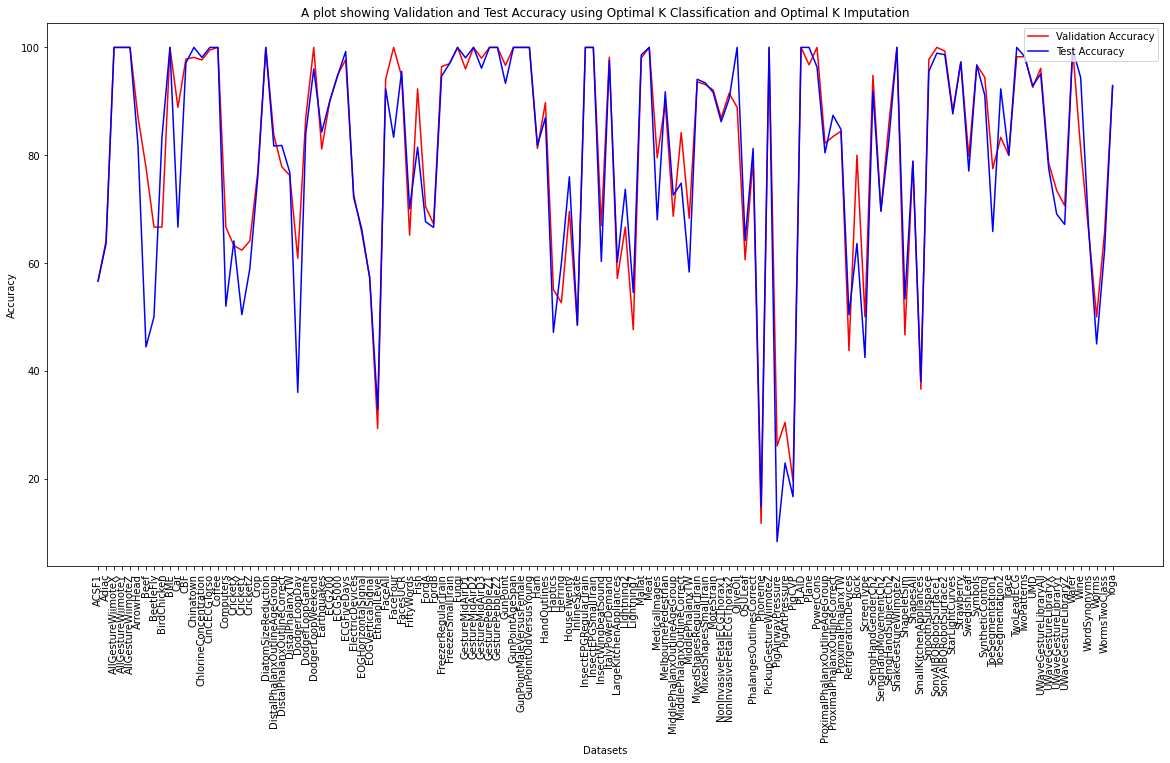

In [25]:
#Creating a Figure
fig = plt.figure(figsize=(20, 10))

#Plotting the Line plot for Validation Accuracy
plt.plot(classification_summary.iloc[:, 0], classification_summary.iloc[:, 3], c = 'r', label = 'Validation Accuracy')

#Plotting the Line plot for Test Accuracy
plt.plot(classification_summary.iloc[:, 0], classification_summary.iloc[:, 4], c = 'b', label = 'Test Accuracy')

#Setting the parameters for the graph
plt.xlabel('Datasets')
plt.ylabel('Accuracy')
plt.title('A plot showing Validation and Test Accuracy using Optimal K Classification and Optimal K Imputation')
plt.xticks(rotation=90)
plt.legend(loc=1)

#Showing the Graph
plt.show()

### Exercise 2: Time Series Classification with Various Distance Measures

##### Downscaling the number of datasets and taking first 10 datasets for processing

In [29]:
#Taking the first 10 dataset for this experimentation
ten_datasets = datasets['Dataset'][:10]

##### Listing different Distance measures from Scipy Package

In [30]:
distance_metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 
                    'jaccard', 'jensenshannon', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 
                    'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']

##### Creating a Dictionary to store all the statistics of different datasets for this experiment

In [31]:
dataset_accuracy = {'Name' : [],                #Contains the Name of Datasets
                    'K' : [],                   #Contains the Optimum K value found using Grid Search for each Dataset
                    'Distance Metric' : [],     #Contains the Best Distance Measure found using Grid Search for each Dataset
                    'Validation Accuracy' : [], #Contains the Best Validation accuracy achieved using the Optimum K value and Optimum Distance Measure
                    'Test Accuracy' : []        #Contains the Test Accuracy achieved using Optimum K and Distance Measure from Validation set
                   }

##### For each distance measure and for each dataset in the consideration, using the validation samples to tune the parameter K and selecting one best  distance measure.

In [32]:
#Iterating/Enumerating through all the selected datasets
for index ,dataset in enumerate(ten_datasets):
    
    #Creating a accuracy matrix which will contain the accuracy for each combination of k and distance measure
    accuracy_matrix = np.zeros(shape=(len(distance_metrics) ,5))
    
    #Splitting the dataset into Train, Validation and Test splits
    X_train, Y_train, X_test, Y_test, X_val, Y_val = stratify_split_dataframe(dataset, 0.7, 0.15, 0.15)
    
    #Iterating through the range of different K values, taking K from [1,2,3,4,5]
    for k_classification in range(1 ,6):
        
        #Iterating/Enumerating through different distance measures
        for dist_index ,dist_met in enumerate(distance_metrics):
            
            #Creating an empty array to store the predicted classes for the validation set
            predicted_class_val = []
            
            #Iterating through all the observations in the Validation set
            for x_val in X_val:
                
                #Predicting the class for the single validation set observation using scipy distance measure
                pred_class = predict_knn_class(X_train, Y_train, x_val, k_classification, True, dist_met)
                
                #Appending the predicted class to the created array
                predicted_class_val.append(pred_class)
            
            #After predicting the classes for all validation set observation, now calculating it overall accuracy
            accuracy = accuracy_knn_classification(predicted_class_val, Y_val.ravel())
            
            #Saving the accuracy in our Accuracy Matrix for current Combination
            accuracy_matrix[dist_index,k_classification - 1] = accuracy
    
    #Finding the combination with the highest accuracy for the current Dataset
    optimum_point = np.where(accuracy_matrix == np.amax(accuracy_matrix))
    optimum_dist_met , optimum_k = optimum_point[0][0] , optimum_point[1][0]
    
    #Creating an empty array to store the predicted classes for the Test set
    predicted_class_test = []
    
    #Iterating through all the observations in the Test set
    for x_test in X_test:
        
        #Predicting the class for the single Test set observation using Optimum K and Optimum scipy distance measure
        pred_class = predict_knn_class(X_train, Y_train, x_test, optimum_k + 1, True, distance_metrics[optimum_dist_met])
        
        #Appending the predicted class to the created array
        predicted_class_test.append(pred_class)
    
    #After predicting the classes for all Test set observation, now calculating it overall accuracy
    test_accuracy = accuracy_knn_classification(predicted_class_test, Y_test.ravel())
    
    #Appending the Optimum combination of K and Distance measure for the current Dataset in the dictionary
    dataset_accuracy['Name'].append(datasets['Name'][index])
    dataset_accuracy['K'].append(optimum_k + 1)
    dataset_accuracy['Distance Metric'].append(distance_metrics[optimum_dist_met])
    dataset_accuracy['Validation Accuracy'].append(accuracy_matrix[optimum_dist_met,optimum_k])
    dataset_accuracy['Test Accuracy'].append(test_accuracy)
    
    #Printing the Optimum Combination for the current Dataset
    print('The Best K value and the Best Distance Metric for Dataset:\nDataset Name: {}\t Validation Accuracy: {}\tTest Accuracy: {}\nBest K: {}\tBest Distance Metric: {}\n'.format(
          datasets['Name'][index], accuracy_matrix[optimum_dist_met,optimum_k], test_accuracy, optimum_k + 1, distance_metrics[optimum_dist_met]))

The Best K value and the Best Distance Metric for Dataset:
Dataset Name: ACSF1	 Validation Accuracy: 83.33333333333334	Test Accuracy: 73.33333333333333
Best K: 1	Best Distance Metric: braycurtis

The Best K value and the Best Distance Metric for Dataset:
Dataset Name: Adiac	 Validation Accuracy: 70.08547008547008	Test Accuracy: 68.64406779661016
Best K: 1	Best Distance Metric: chebyshev

The Best K value and the Best Distance Metric for Dataset:
Dataset Name: AllGestureWiimoteX	 Validation Accuracy: 100.0	Test Accuracy: 100.0
Best K: 1	Best Distance Metric: braycurtis

The Best K value and the Best Distance Metric for Dataset:
Dataset Name: AllGestureWiimoteY	 Validation Accuracy: 100.0	Test Accuracy: 100.0
Best K: 1	Best Distance Metric: braycurtis

The Best K value and the Best Distance Metric for Dataset:
Dataset Name: AllGestureWiimoteZ	 Validation Accuracy: 100.0	Test Accuracy: 100.0
Best K: 1	Best Distance Metric: braycurtis

The Best K value and the Best Distance Metric for Data

##### Aggregating the results across all 10 datasets, and rank all distance metrics according to the test accuracy

In [34]:
#Converting dictionary to the dataframe for displaying the results of Accuracy of Validation and Test accross datasets
scipy_summary = pd.DataFrame.from_dict(dataset_accuracy)
scipy_summary

,Name,K,Distance Metric,Validation Accuracy,Test Accuracy
0,ACSF1,1,braycurtis,83.333333,73.333333
1,Adiac,1,chebyshev,70.085470,68.644068
2,AllGestureWiimoteX,1,braycurtis,100.000000,100.000000
3,AllGestureWiimoteY,1,braycurtis,100.000000,100.000000
4,AllGestureWiimoteZ,1,braycurtis,100.000000,100.000000
5,ArrowHead,1,braycurtis,90.322581,75.757576
6,Beef,4,chebyshev,88.888889,44.444444
7,BeetleFly,1,braycurtis,66.666667,66.666667
8,BirdChicken,1,chebyshev,83.333333,83.333333
9,BME,1,canberra,100.000000,100.000000


##### Plotting Validation and Test Accuracy in one Plot

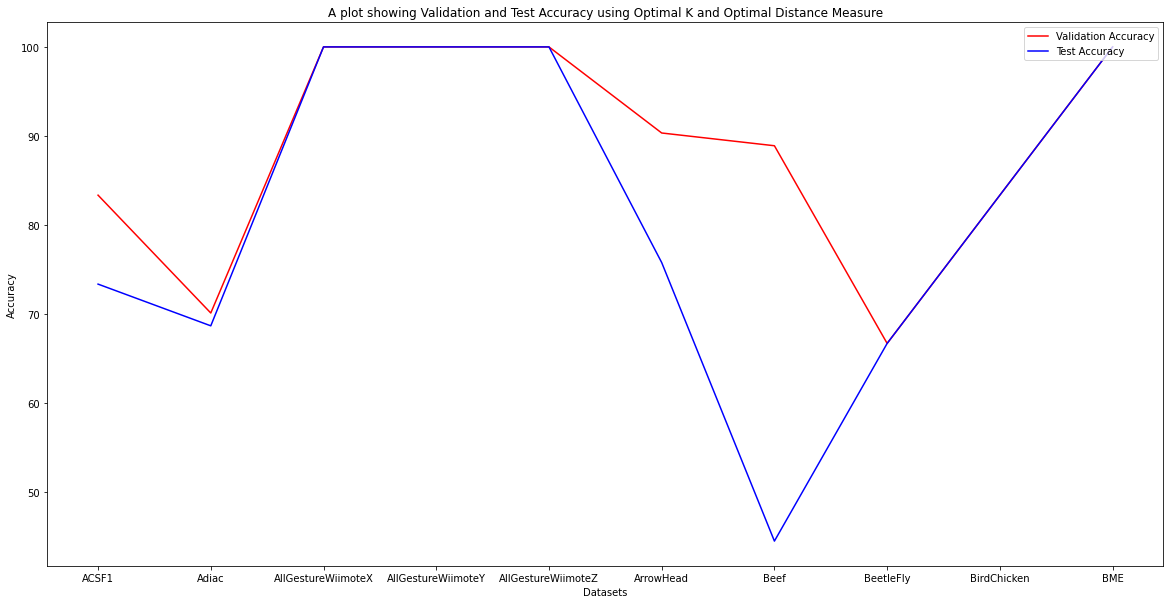

In [35]:
#Creating a Figure
fig = plt.figure(figsize=(20, 10))

#Plotting the Line plot for Validation Accuracy
plt.plot(scipy_summary.iloc[:, 0], scipy_summary.iloc[:, 3], c = 'r', label = 'Validation Accuracy')

#Plotting the Line plot for Test Accuracy
plt.plot(scipy_summary.iloc[:, 0], scipy_summary.iloc[:, 4], c = 'b', label = 'Test Accuracy')

#Setting the parameters for the graph
plt.xlabel('Datasets')
plt.ylabel('Accuracy')
plt.title('A plot showing Validation and Test Accuracy using Optimal K and Optimal Distance Measure')
plt.legend(loc=1)

#Showing the Graph
plt.show()

### Exercise 3: Accelerating K-Nearest Neighbour Classifier

##### Partial Distances/Lower Bounding

###### Function to perform KNN classification using partial distance and Lower bounding

In [36]:
def partial_distance(trainX,trainY, query, k):
    
    #Creating an array to store distances of k nearest neighbours
    distance_array_k = np.zeros(shape=(k,), dtype='i,i')
    
    #Iterating first through the first K rows to find the nearest neighbour to the quering row
    for index, row in enumerate(trainX[:k,:]):
        
        #Appending the calculated euclidean distance to the created distance array
        distance_array_k[index] = (index, calculate_euclidean_distance_numpy(query ,row))
    
    #Sorting the distance array based on distance so that we can check for better neighbour later
    distance_array_k = sorted(distance_array_k, key=lambda x:x[1])
    
    #Now Iterating through all rows after first K rows
    for index, row in enumerate(trainX[k:,:]):
        
        #Initializing variable for distance and taken features
        d = 0
        m = 1
        
        #we have to iterate until we have calculate the distance with respect to every feature and the calculated distance is smaller than previous
        while m < trainX.shape[1] & d <  calculate_euclidean_distance_numpy(query[:m], row[:m]):
            
            #Adding the distance to the variable
            d += np.sum(np.square(query[:m] , row[:m]))
            
            #Incrementing the variable m which indicates that in next iteration we have to take one more feature for calculating distance
            m += 1
            
        #Checking if our calculated distance is better than the distance calculated before with all features
        if d < calculate_euclidean_distance_numpy(query ,row):
            
            #If yes, than appending that row to our K nearest neighbour distance array
            temp_arr = distance_array_k.copy()
            temp_arr.append((index,d))
            temp_arr = sorted(temp_arr, key=lambda x:x[1])
            distance_array_k = temp_arr[:-1]
    
    #Getting the classes of these nearest rows
    k_nearest_class = trainY[[i[0] for i in distance_array_k]]
    
    #The predicted class is then the maximum occuring class
    values, counts = np.unique(k_nearest_class, return_counts=True)
    predicted_class = values[np.argmax(counts)]
    
    #Returning the Predicted class
    return predicted_class  

###### Finding the Dataset with the largest number of Samples

In [37]:
print('The Dataset with the largest number of Samples is: \n')
print(dataset_info.iloc[dataset_info['Total Rows'].idxmax(),:])

The Dataset with the largest number of Samples is: 

Name              Crop
Total Columns       47
Total Rows       24000
Total Classes       24
Null Values      False
Name: 20, dtype: object


###### Extracting the biggest Dataset from the list

In [38]:
biggest_dataset = datasets['Dataset'][datasets['Name'].index('Crop')]
biggest_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,1,0.240,0.257,0.274,0.25700,0.27700,0.29700,0.317,0.29325,0.26950,...,0.41475,0.38850,0.36225,0.336,0.324,0.312,0.3310,0.350,0.333,0.316
1,1,0.219,0.209,0.199,0.21567,0.23233,0.24900,0.237,0.18500,0.20300,...,0.36900,0.36200,0.35500,0.348,0.405,0.351,0.2950,0.239,0.218,0.197
2,1,0.281,0.240,0.199,0.20000,0.23400,0.26800,0.264,0.32200,0.29933,...,0.32300,0.32800,0.33300,0.259,0.308,0.264,0.2750,0.286,0.306,0.326
3,1,0.125,0.218,0.311,0.26900,0.33000,0.39100,0.237,0.15300,0.14675,...,0.54367,0.43733,0.33100,0.251,0.249,0.277,0.2795,0.282,0.277,0.272
4,1,0.117,0.144,0.171,0.18975,0.20850,0.22725,0.246,0.21300,0.21700,...,0.40200,0.32500,0.24800,0.171,0.167,0.144,0.1485,0.153,0.152,0.151


###### Doing Grid search on K with Partial Distance KNN and the Biggest Dataset: 'Crop'

In [39]:
#Creating a accuracy matrix which will contain the accuracy for each combination of K classification and K Imputation
accuracy_arr = np.zeros(shape=(5,))

#Splitting the dataset into Train, Validation and Test sets
Crop_X_train, Crop_Y_train, Crop_X_test, Crop_Y_test, Crop_X_val, Crop_Y_val = stratify_split_dataframe(biggest_dataset, 0.7, 0.15, 0.15)

#Iterating through different values of K for KNN Classification, Picking K from [1,2,3,4,5]
for k_classification in range(1, 6):

    #Creating an array to store the predicated classes for validation set
    predicted_class_val = []

    #Iterating through each observation in the Validation set
    for x_val in Crop_X_val:

        #Predicting the class of validation row using the specific K and Train set
        pred_class = partial_distance(Crop_X_train, Crop_Y_train, x_val, k_classification)

        #Appending the predicted class to the created array
        predicted_class_val.append(pred_class)

    #Now calculating the total accuracy of the Validation set
    accuracy = accuracy_knn_classification(predicted_class_val, Crop_Y_val.ravel())

    #Saving the accuracy in our Accuracy Matrix for current Combination
    accuracy_arr[k_classification - 1] = accuracy

#Finding the combination with the highest accuracy for the current Dataset
optimum_point = np.where(accuracy_arr == np.amax(accuracy_arr))
optimum_k_classification = optimum_point[0][0]

#Creating an empty array to store the predicted classes for the Test set
predicted_class_test = []

#Iterating through all the observations in the Test set
for x_test in Crop_X_test:

    #Predicting the class of Test row using the specific K and Train set
    pred_class = partial_distance(Crop_X_train, Crop_Y_train, x_test, optimum_k_classification + 1)

    #Appending the predicted class to the created array
    predicted_class_test.append(pred_class)

#After predicting the classes for all Test set observation, now calculating it overall accuracy
test_accuracy = accuracy_knn_classification(predicted_class_test, Crop_Y_test.ravel())

#Printing the Optimum Combination for the current Dataset
print('The Best Classification K value for Dataset:\nDataset Name: Crop\t Validation Accuracy: {}\tTest Accuracy: {}\nBest Classification K: {}\n'.format(
      accuracy_arr[optimum_k_classification], test_accuracy, optimum_k_classification + 1))

The Best Classification K value for Dataset:
Dataset Name: Crop	 Validation Accuracy: 11.833333333333334	Test Accuracy: 11.805555555555555
Best Classification K: 3



##### Locality Sensitive Hashing
Reference Website: https://towardsdatascience.com/locality-sensitive-hashing-for-music-search-f2f1940ace23

###### Function to calculate the Hash value using Random Projection/ Simhash

In [40]:
def simHash(random_vector, observation):
    #For each value of dot product, we will check if the value is greater than 0 or not and appending it as a string
    bools = ''.join((np.dot(random_vector, observation) > 0).astype('int').astype('str'))
    
    #Returning the final hash value
    return bools

###### Function to Create and Populate the hashtable with train rows data

In [41]:
def create_populate_hashtables(trainX, k):
    #Creating k different Random vectors to denote k different hyperplanes
    random_vectors = np.random.randn(k,len(trainX[0]))
    
    #Creating and Initializing an empty hash table to store my hash values for training rows
    hashtable = []
    
    ##Iterating through all training rows and storing there hash values in the hash table
    for index , row in enumerate(trainX):
        
        #Calculating hash value of training row using SimHash
        hashvalue = simHash(random_vectors, row)
        
        #Appending the hash value to the hash table
        hashtable.append(hashvalue)
    
    #Returning the hash table and the random vectors
    return hashtable , random_vectors

###### Function to perform KNN classification using Locally Sensitive Hashing

In [42]:
def locally_sensitive_hashing(trainX, trainY, validationX, k):
    #Creating and Populating Hash tables for training data and Creating the random vectors for Hashing
    hashtable, random_vectors = create_populate_hashtables(trainX, k)
    
    #Creating and Initializing an empty array to store the predicted classes for the validation set
    predicted_classes_val = []
    
    #Iterating through all the rows in Validation set to Predict there classes
    for index, val_row in enumerate(validationX):
        
        #Calculating the hash value of the validation row
        val_hash = simHash(random_vectors, val_row)
        
        #Initializing the predicted class variable with None
        val_predicted_class = None
        
        try:
            #Searching the hash table to find the index with the same hash value as the validation row
            train_index = hashtable.index(val_hash)

            #Extracting the class of training row which is close to the validation found using hash table
            val_predicted_class = trainY[train_index]
        except:
            
            #Assiging class to infinity since we were not able find the class using LSH method
            val_predicted_class = np.iinfo(np.int32).max
            
        #Appending the predicted class to the array
        predicted_classes_val.append(val_predicted_class)
        
    #Returning the predicted class array
    return predicted_classes_val

###### Doing Grid search on K with Locally Sensitive Hashing KNN and the Biggest Dataset: 'Crop'

In [43]:
#Creating a accuracy matrix which will contain the accuracy for each combination of K classification and K Imputation
accuracy_arr = np.zeros(shape=(5,))

#Splitting the dataset into Train, Validation and Test sets
Crop_X_train, Crop_Y_train, Crop_X_test, Crop_Y_test, Crop_X_val, Crop_Y_val = stratify_split_dataframe(biggest_dataset, 0.7, 0.15, 0.15)

#Iterating through different values of K for KNN Classification, Picking K from [1,2,3,4,5]
for k_classification in range(1, 6):

    #Creating an array to store the predicated classes for validation set
    predicted_class_val = []

    #Predicting the class of validation row using the specific K and Train set
    predicted_class_val = locally_sensitive_hashing(Crop_X_train, Crop_Y_train, Crop_X_val, k_classification)

    #Now calculating the total accuracy of the Validation set
    accuracy = accuracy_knn_classification(predicted_class_val, Crop_Y_val.ravel())

    #Saving the accuracy in our Accuracy Matrix for current Combination
    accuracy_arr[k_classification - 1] = accuracy

#Finding the combination with the highest accuracy for the current Dataset
optimum_point = np.where(accuracy_arr == np.amax(accuracy_arr))
optimum_k_classification = optimum_point[0][0]

#Creating an empty array to store the predicted classes for the Test set
predicted_class_test = []

#Predicting the class of Test row using the specific K and Train set
predicted_class_test = locally_sensitive_hashing(Crop_X_train, Crop_Y_train, Crop_X_test, optimum_k_classification + 1)

#After predicting the classes for all Test set observation, now calculating it overall accuracy
test_accuracy = accuracy_knn_classification(predicted_class_test, Crop_Y_test.ravel())

#Printing the Optimum Combination for the current Dataset
print('The Best Classification K value for Dataset:\nDataset Name: Crop\t Validation Accuracy: {}\tTest Accuracy: {}\nBest Classification K: {}\n'.format(
      accuracy_arr[optimum_k_classification], test_accuracy, optimum_k_classification + 1))

The Best Classification K value for Dataset:
Dataset Name: Crop	 Validation Accuracy: 11.25	Test Accuracy: 4.861111111111112
Best Classification K: 4

